### Aggregate and prepare cluster level data

In [1]:
import pandas as pd
import numpy as np
import holidays
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

KeyboardInterrupt: 

In [2]:
import pandas as pd
import numpy as np
import holidays

def data_preprocessing_hourly(
    trips_parquet='filtered_df_2.parquet',
    clusters_csv='df_clusters.csv'
):
    """
    Loads the taxi trips and cluster info, merges them,
    computes pickup counts per cluster per hour,
    and adds cyclical time-of-day, day-of-week, month, holiday features.
    Returns df_hourly.
    """
    # Load taxi trips
    df_trips = pd.read_parquet(trips_parquet)
    # Load cluster info
    df_clusters = pd.read_csv(clusters_csv)
    
    # Merge
    df_trips = df_trips.merge(df_clusters, left_on="PULocationID", right_on="zone_id", how="left")
    
    # Ensure datetime
    df_trips['tpep_pickup_datetime'] = pd.to_datetime(df_trips['tpep_pickup_datetime'])
    
    # Extract hour
    df_trips['pickup_hour'] = df_trips['tpep_pickup_datetime'].dt.floor('H')  # Round down to the hour
    
    # Group by cluster & hour
    df_hourly = df_trips.groupby(['cluster', 'pickup_hour']).size().reset_index(name='pickup_count')
    
    # Basic time features
    df_hourly['day_of_week'] = df_hourly['pickup_hour'].dt.weekday  # Monday=0, Sunday=6
    df_hourly['month']       = df_hourly['pickup_hour'].dt.month
    df_hourly['hour']        = df_hourly['pickup_hour'].dt.hour  # Hour of day (0-23)

    # Holiday indicator
    us_holidays = holidays.UnitedStates()
    df_hourly['is_holiday'] = df_hourly['pickup_hour'].dt.date.apply(lambda x: 1 if x in us_holidays else 0)
    
    # Cyclical encoding for day-of-week
    df_hourly['dow_sin'] = np.sin(2 * np.pi * df_hourly['day_of_week'] / 7)
    df_hourly['dow_cos'] = np.cos(2 * np.pi * df_hourly['day_of_week'] / 7)
    
    # Cyclical encoding for month
    df_hourly['month_sin'] = np.sin(2 * np.pi * (df_hourly['month'] - 1) / 12)
    df_hourly['month_cos'] = np.cos(2 * np.pi * (df_hourly['month'] - 1) / 12)
    
    # Cyclical encoding for hour of day
    df_hourly['hour_sin'] = np.sin(2 * np.pi * df_hourly['hour'] / 24)
    df_hourly['hour_cos'] = np.cos(2 * np.pi * df_hourly['hour'] / 24)
    
    # Sort by cluster & hour
    df_hourly = df_hourly.sort_values(['cluster', 'pickup_hour']).reset_index(drop=True)
    
    return df_hourly

# Apply the function
df_hourly = data_preprocessing_hourly(
    trips_parquet='filtered_df_2.parquet',
    clusters_csv='df_clusters.csv'
)

# Display result
df_hourly

,cluster,pickup_hour,pickup_count,day_of_week,month,hour,is_holiday,dow_sin,dow_cos,month_sin,month_cos,hour_sin,hour_cos
0,0,2023-11-01 00:00:00,1205,2,11,0,0,0.974928,-0.222521,-0.866025,0.5,0.000000,1.000000
1,0,2023-11-01 01:00:00,732,2,11,1,0,0.974928,-0.222521,-0.866025,0.5,0.258819,0.965926
2,0,2023-11-01 02:00:00,535,2,11,2,0,0.974928,-0.222521,-0.866025,0.5,0.500000,0.866025
3,0,2023-11-01 03:00:00,400,2,11,3,0,0.974928,-0.222521,-0.866025,0.5,0.707107,0.707107
4,0,2023-11-01 04:00:00,336,2,11,4,0,0.974928,-0.222521,-0.866025,0.5,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28214,4,2024-09-29 15:00:00,1,6,9,15,0,-0.781831,0.623490,-0.866025,-0.5,-0.707107,-0.707107
28215,4,2024-09-29 16:00:00,1,6,9,16,0,-0.781831,0.623490,-0.866025,-0.5,-0.866025,-0.500000
28216,4,2024-09-29 19:00:00,1,6,9,19,0,-0.781831,0.623490,-0.866025,-0.5,-0.965926,0.258819
28217,4,2024-09-29 21:00:00,2,6,9,21,0,-0.781831,0.623490,-0.866025,-0.5,-0.707107,0.707107


In [14]:
# Sequence Generation Function
def create_sequences(df, feature_cols, target_col, time_steps):
    """
    Generates input sequences and corresponding targets for LSTM.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        feature_cols (list): List of feature column names.
        target_col (str): The target column name.
        time_steps (int): Number of time steps in each input sequence.

    Returns:
        X (np.ndarray): Input sequences.
        y (np.ndarray): Corresponding targets.
    """
    X, y = [], []
    for i in range(len(df) - time_steps):
        X.append(df[feature_cols].iloc[i:i + time_steps].values)
        y.append(df[target_col].iloc[i + time_steps])
    return np.array(X), np.array(y)

In [15]:
# LSTM Training Function
def train_lstm_for_clusters(df_hourly, clusters, feature_cols, target_col, scaler_target, time_steps):
    """
    Train an LSTM model for each cluster and evaluate performance.

    Args:
        df_hourly (pd.DataFrame): Preprocessed DataFrame.
        clusters (list): List of unique clusters.
        feature_cols (list): List of feature column names.
        target_col (str): The target column name.
        scaler_target (MinMaxScaler): Scaler used for the target variable.
        time_steps (int): Number of time steps for LSTM input.

    Returns:
        models (dict): Trained LSTM models for each cluster.
        histories (dict): Training histories for each cluster.
    """
    models = {}
    histories = {}

    for cluster in clusters:
        print(f"Training LSTM for Cluster {cluster}...")

        # Filter data for the cluster
        cluster_data = df_hourly[df_hourly['cluster'] == cluster].reset_index(drop=True)

        # Create sequences
        X, y = create_sequences(cluster_data, feature_cols, target_col, time_steps)

        # Split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, shuffle=False
        )

        # Define the LSTM model
        model = Sequential([
            LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(0.2),
            LSTM(32, activation='relu'),
            Dropout(0.2),
            Dense(1)
        ])

        # Compile the model
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        # Train the model
        history = model.fit(
            X_train, y_train,
            epochs=20,
            batch_size=32,
            validation_data=(X_test, y_test),
            verbose=1
        )

        # Save model and history
        models[cluster] = model
        histories[cluster] = history

        # Evaluate the model
        loss, mae = model.evaluate(X_test, y_test, verbose=0)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        print(f"Cluster {cluster} - Test Loss: {loss:.4f}, Test MAE: {mae:.4f}, Test RMSE: {rmse:.4f}")

        # Plot training and validation loss
        plt.figure(figsize=(10, 4))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Cluster {cluster} - Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    return models, histories

In [16]:
# Visualization Function
def visualize_predictions_by_cluster(df_hourly, clusters, models, scaler_target, feature_cols, time_steps):
    """
    Visualizes predictions versus actual values for each cluster.

    Args:
        df_hourly (pd.DataFrame): Original DataFrame containing cluster data.
        clusters (list): List of unique cluster IDs.
        models (dict): Dictionary of trained LSTM models for each cluster.
        scaler_target (MinMaxScaler): Scaler used for the target variable.
        feature_cols (list): List of feature column names.
        time_steps (int): Number of time steps in the sequence.
    """
    for cluster in clusters:
        print(f"Visualizing predictions for Cluster {cluster}...")

        # Filter data for the cluster
        cluster_data = df_hourly[df_hourly['cluster'] == cluster].reset_index(drop=True)

        # Create sequences
        X, y = create_sequences(cluster_data, feature_cols, 'pickup_count_scaled', time_steps)

        # Retrieve the model
        model = models[cluster]

        # Make predictions
        y_pred_scaled = model.predict(X)

        # Inverse transform the scaled predictions and actual values
        y_pred = scaler_target.inverse_transform(y_pred_scaled)
        y_actual = scaler_target.inverse_transform(y.reshape(-1, 1))

        # Plot actual vs predicted
        plt.figure(figsize=(14, 6))
        plt.plot(y_actual, label='Actual Pickup Count', color='blue')
        plt.plot(y_pred, label='Predicted Pickup Count', color='red')
        plt.title(f'Cluster {cluster} - Actual vs Predicted Pickup Counts')
        plt.xlabel('Time Steps')
        plt.ylabel('Pickup Count')
        plt.legend()
        plt.show()

Training LSTM for Cluster 0...
Epoch 1/20


/dcs/pg24/u2164966/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0676 - mae: 0.1989 - val_loss: 0.0075 - val_mae: 0.0664
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0131 - mae: 0.0896 - val_loss: 0.0060 - val_mae: 0.0563
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0100 - mae: 0.0763 - val_loss: 0.0045 - val_mae: 0.0509
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0086 - mae: 0.0717 - val_loss: 0.0031 - val_mae: 0.0431
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0080 - mae: 0.0674 - val_loss: 0.0080 - val_mae: 0.0623
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0074 - mae: 0.0641 - val_loss: 0.0053 - val_mae: 0.0518
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0067 - mae: 0.0612 - val_loss: 0.0027 - val_mae: 0.0381
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0067 - mae: 0.0607 - val_loss: 0.0054 - val_mae: 0.0503
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 

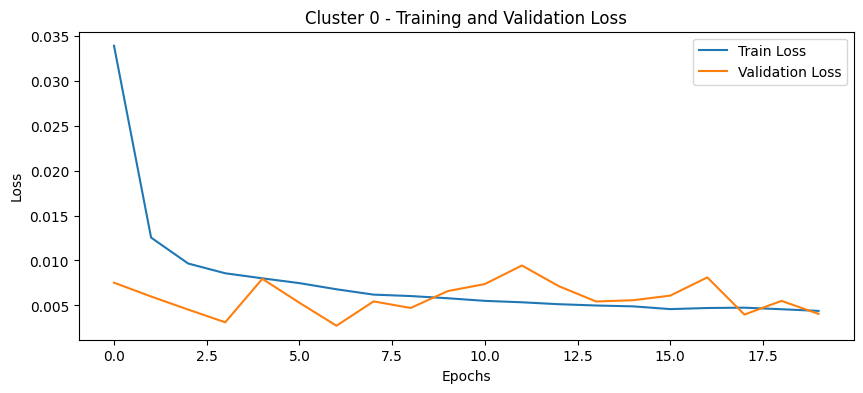

Training LSTM for Cluster 1...
Epoch 1/20


/dcs/pg24/u2164966/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0016 - mae: 0.0312 - val_loss: 3.2688e-05 - val_mae: 0.0043
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.7380e-04 - mae: 0.0128 - val_loss: 1.9522e-05 - val_mae: 0.0032
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0572e-04 - mae: 0.0083 - val_loss: 9.6586e-06 - val_mae: 0.0026
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.4772e-05 - mae: 0.0059 - val_loss: 8.5054e-06 - val_mae: 0.0027
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.8136e-05 - mae: 0.0042 - val_loss: 4.7112e-06 - val_mae: 0.0020
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5557e-05 - mae: 0.0031 - val_loss: 3.5464e-06 - val_mae: 0.0017
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1166e-05 - mae: 0.0026 - val_loss: 1.3319e-06 - val_mae: 0.0010
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.1353e-06 - mae: 0.0024 - val_loss: 1.6699e-06 - val_mae: 0.0012
Epoch 9/20
14/1

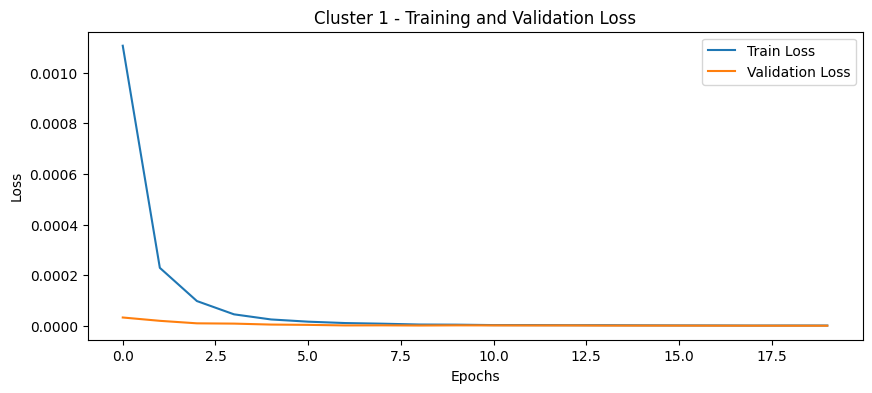

Training LSTM for Cluster 2...
Epoch 1/20


/dcs/pg24/u2164966/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0028 - mae: 0.0374 - val_loss: 9.5525e-04 - val_mae: 0.0190
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 7.7912e-04 - mae: 0.0197 - val_loss: 6.3687e-04 - val_mae: 0.0158
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.3889e-04 - mae: 0.0158 - val_loss: 5.4289e-04 - val_mae: 0.0154
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.2915e-04 - mae: 0.0141 - val_loss: 5.5224e-04 - val_mae: 0.0158
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.6163e-04 - mae: 0.0144 - val_loss: 3.3424e-04 - val_mae: 0.0129
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.8744e-04 - mae: 0.0134 - val_loss: 3.6197e-04 - val_mae: 0.0132
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.7806e-04 - mae: 0.0131 - val_loss: 5.9597e-04 - val_mae: 0.0175
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.5752e-04 - mae: 0.0128 - val_loss: 4.3760e-04 - val_mae: 0.0132
E

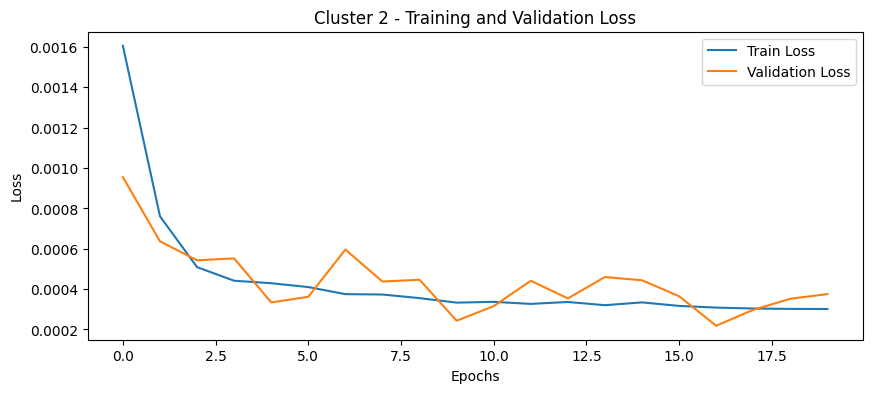

Training LSTM for Cluster 3...
Epoch 1/20


/dcs/pg24/u2164966/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.0884e-04 - mae: 0.0124 - val_loss: 1.1378e-06 - val_mae: 8.3762e-04
Epoch 2/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.6808e-06 - mae: 0.0012 - val_loss: 5.7536e-07 - val_mae: 4.9974e-04
Epoch 3/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 9.3936e-07 - mae: 6.8838e-04 - val_loss: 4.9136e-07 - val_mae: 4.3841e-04
Epoch 4/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.8149e-07 - mae: 5.2240e-04 - val_loss: 4.5544e-07 - val_mae: 4.1579e-04
Epoch 5/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7453e-07 - mae: 4.3255e-04 - val_loss: 4.0404e-07 - val_mae: 4.1139e-04
Epoch 6/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.4514e-07 - mae: 4.0669e-04 - val_loss: 5.1055e-07 - val_mae: 4.5016e-04
Epoch 7/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.4943e-07 - mae: 3.6181e-04 - val_loss: 4.8144e-07 - val_mae: 4.2983e-04
Epoch 8/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.8414e-07 - ma

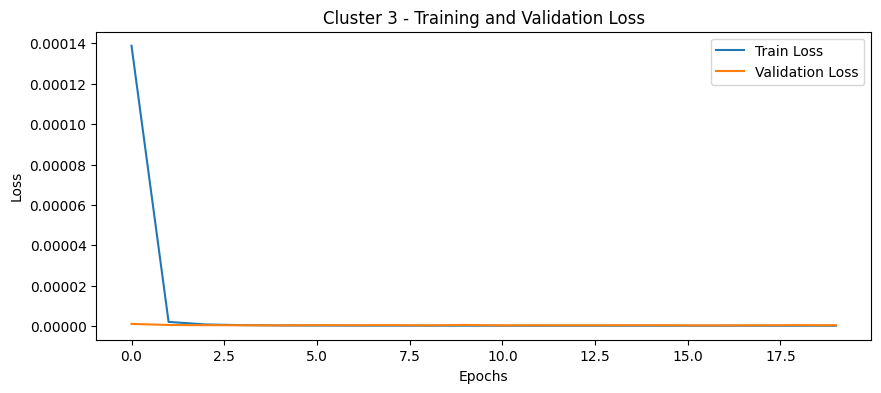

Training LSTM for Cluster 4...
Epoch 1/20


/dcs/pg24/u2164966/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 5.0682e-04 - mae: 0.0140 - val_loss: 2.8124e-05 - val_mae: 0.0029
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.6081e-06 - mae: 0.0022 - val_loss: 2.4023e-05 - val_mae: 0.0022
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.4651e-06 - mae: 0.0012 - val_loss: 2.3511e-05 - val_mae: 0.0020
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3220e-06 - mae: 8.0616e-04 - val_loss: 2.3164e-05 - val_mae: 0.0019
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.8406e-07 - mae: 5.7566e-04 - val_loss: 2.2612e-05 - val_mae: 0.0018
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.0417e-07 - mae: 4.5147e-04 - val_loss: 2.2330e-05 - val_mae: 0.0017
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.9080e-07 - mae: 3.4149e-04 - val_loss: 2.1632e-05 - val_mae: 0.0016
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.9461e-07 - mae: 2.5950e-04 - val_loss: 2.2217e-05 - val_mae:

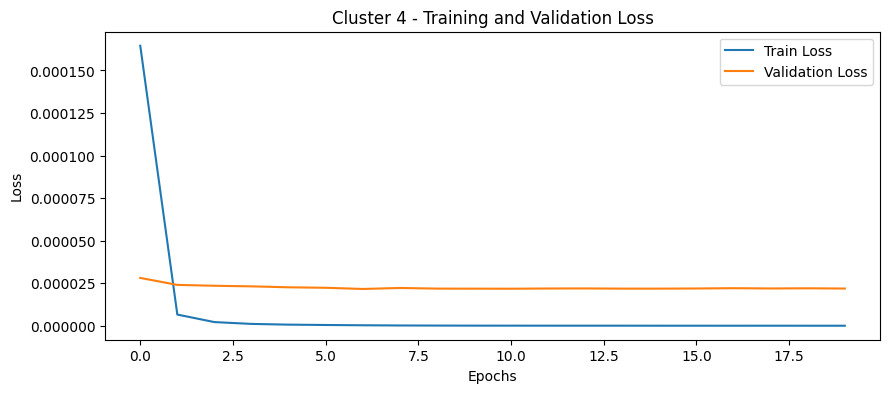

Visualizing predictions for Cluster 0...
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


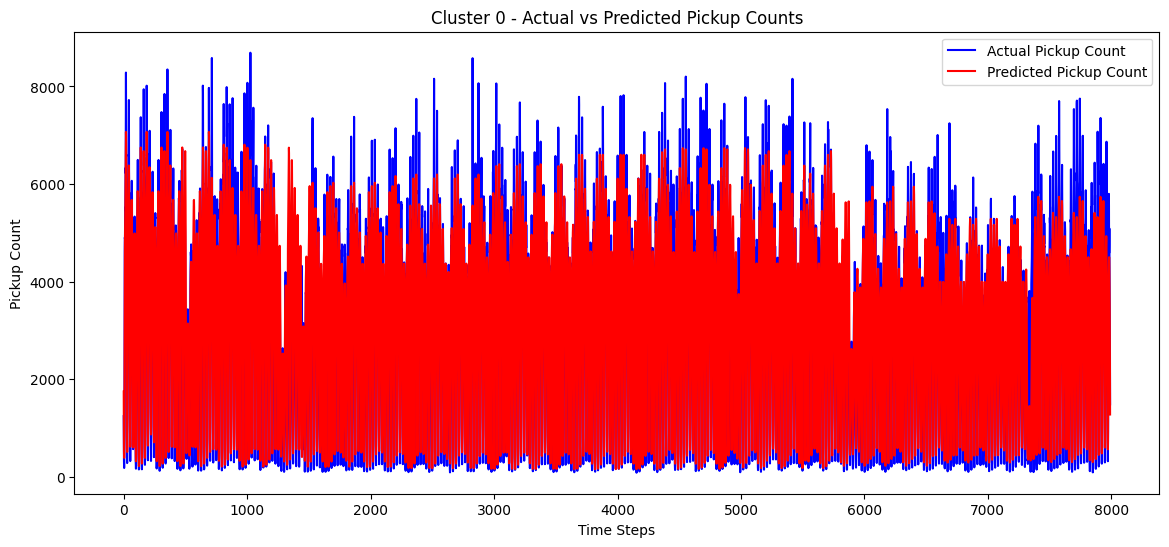

Visualizing predictions for Cluster 1...
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


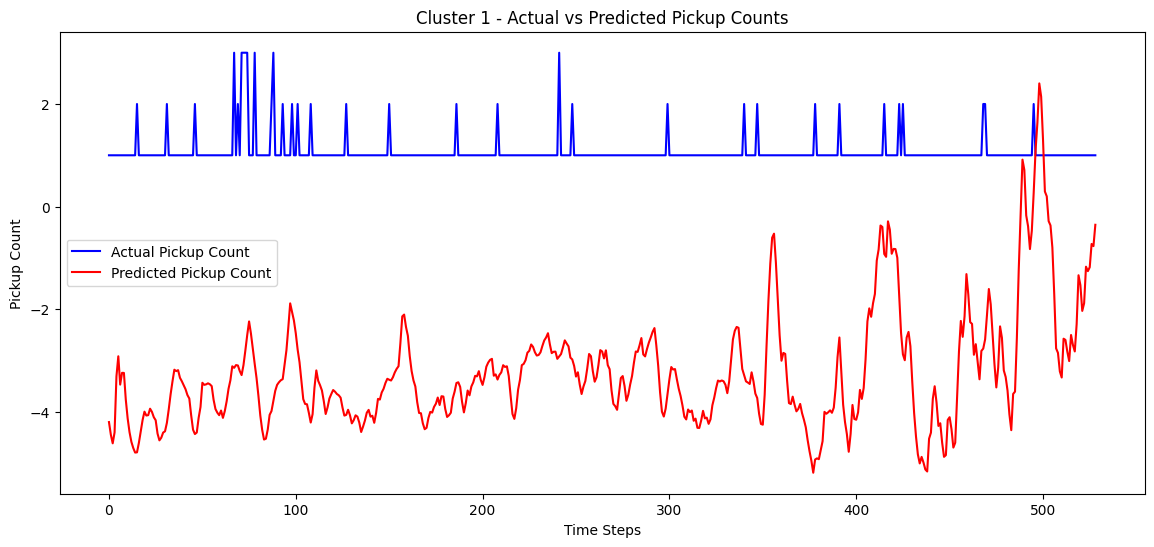

Visualizing predictions for Cluster 2...
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


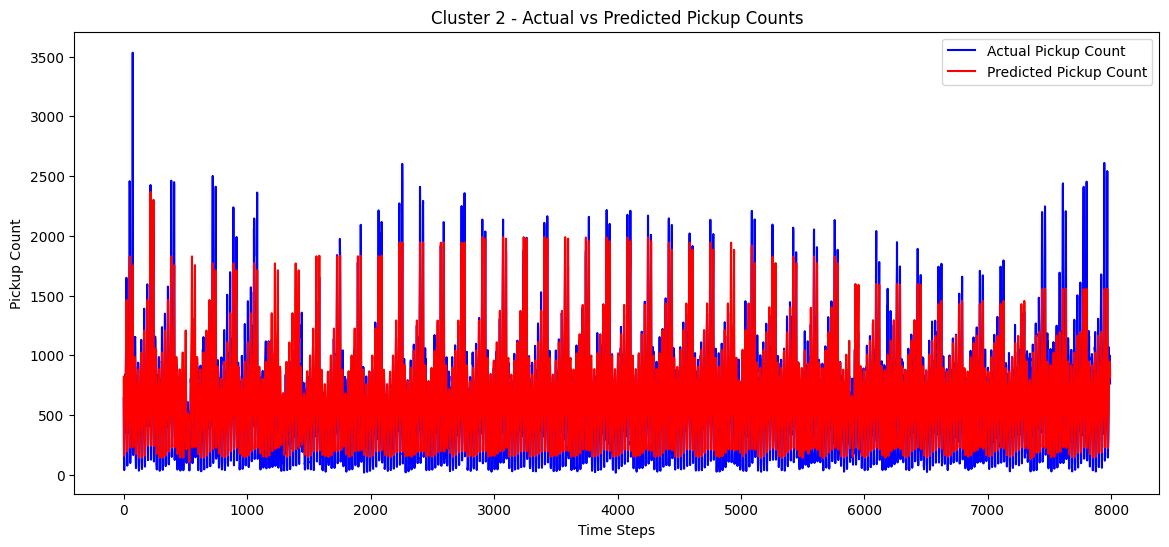

Visualizing predictions for Cluster 3...
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


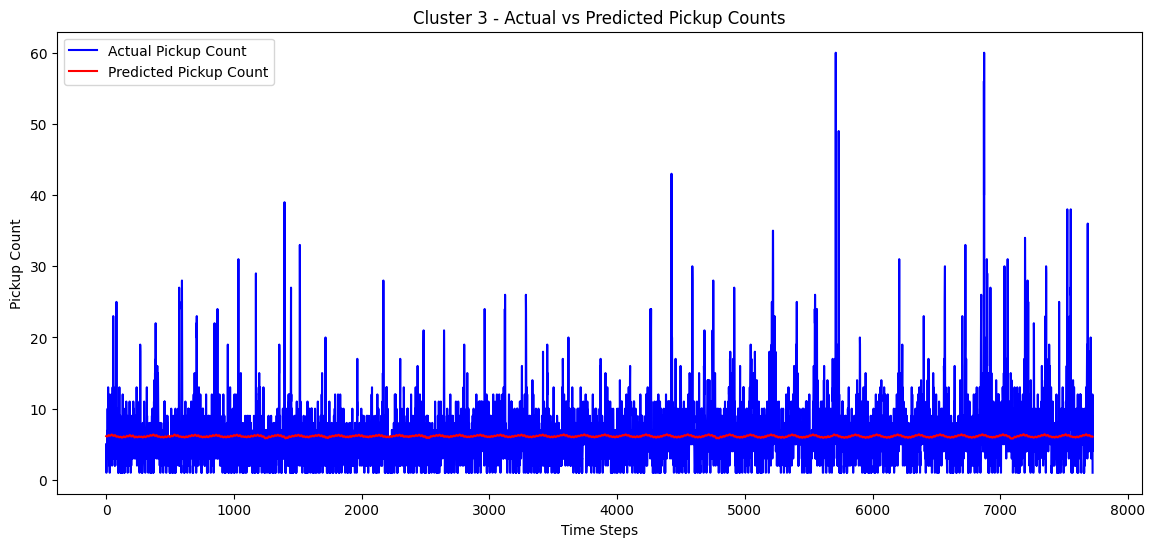

Visualizing predictions for Cluster 4...
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


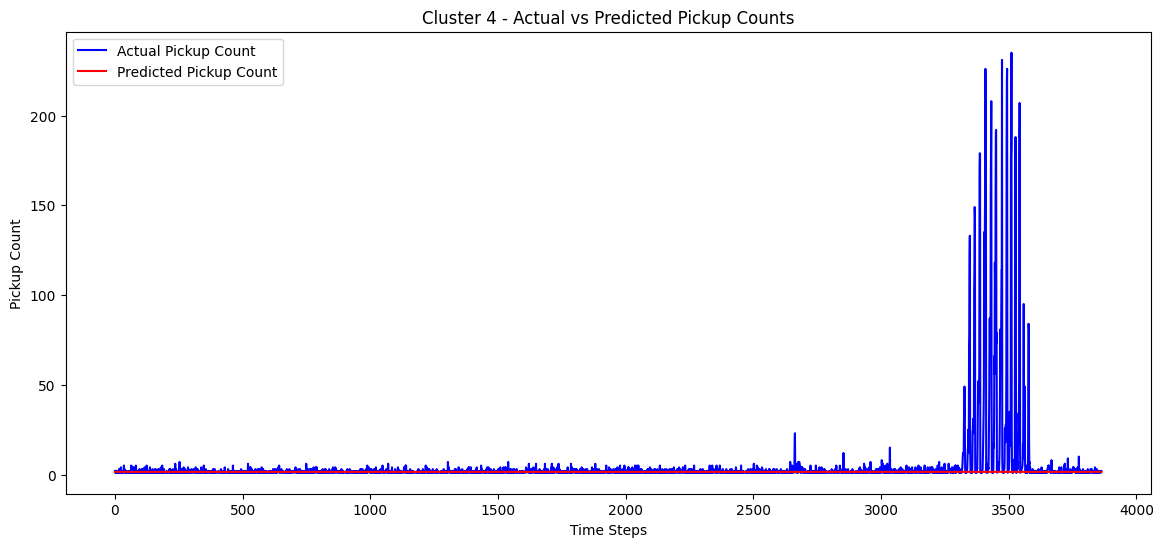

In [17]:
# 1. Data Preprocessing
df_hourly = data_preprocessing_hourly(
    trips_parquet='filtered_df_2.parquet',
    clusters_csv='df_clusters.csv'
)

# 2. Feature Normalization
# Define feature columns excluding the target
feature_cols = ['dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'is_holiday']

# Initialize scaler for features
scaler_features = MinMaxScaler()

# Fit and transform features
df_hourly[feature_cols] = scaler_features.fit_transform(df_hourly[feature_cols])

# Initialize scaler for target
scaler_target = MinMaxScaler()

# Fit and transform target separately
df_hourly['pickup_count_scaled'] = scaler_target.fit_transform(df_hourly[['pickup_count']])

# 3. Train LSTM Models
clusters = df_hourly['cluster'].unique()
target_col = 'pickup_count_scaled'
time_steps = 24  # Using 24 hours as input for prediction

models, histories = train_lstm_for_clusters(
    df_hourly, clusters, feature_cols, target_col, scaler_target, time_steps
)

# 4. Visualize Predictions
visualize_predictions_by_cluster(
    df_hourly, clusters, models, scaler_target, feature_cols, time_steps
)



Training Prophet model for Cluster 0...


06:43:06 - cmdstanpy - INFO - Chain [1] start processing
06:43:06 - cmdstanpy - INFO - Chain [1] done processing


Cluster 0 - MAE: 561.54, RMSE: 712.05


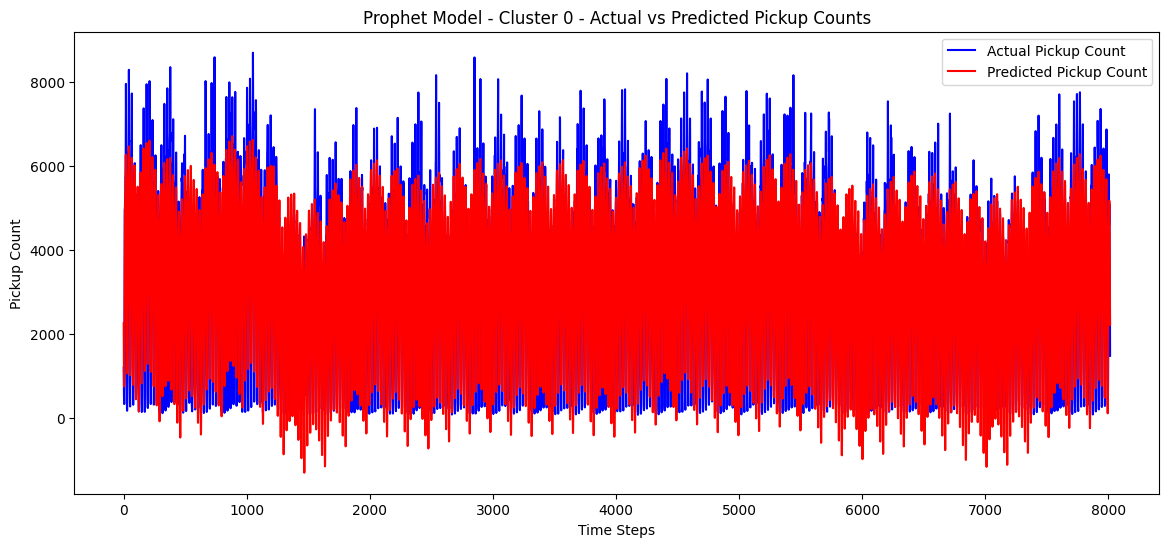

06:43:07 - cmdstanpy - INFO - Chain [1] start processing
06:43:07 - cmdstanpy - INFO - Chain [1] done processing



Training Prophet model for Cluster 1...
Cluster 1 - MAE: 0.15, RMSE: 0.30


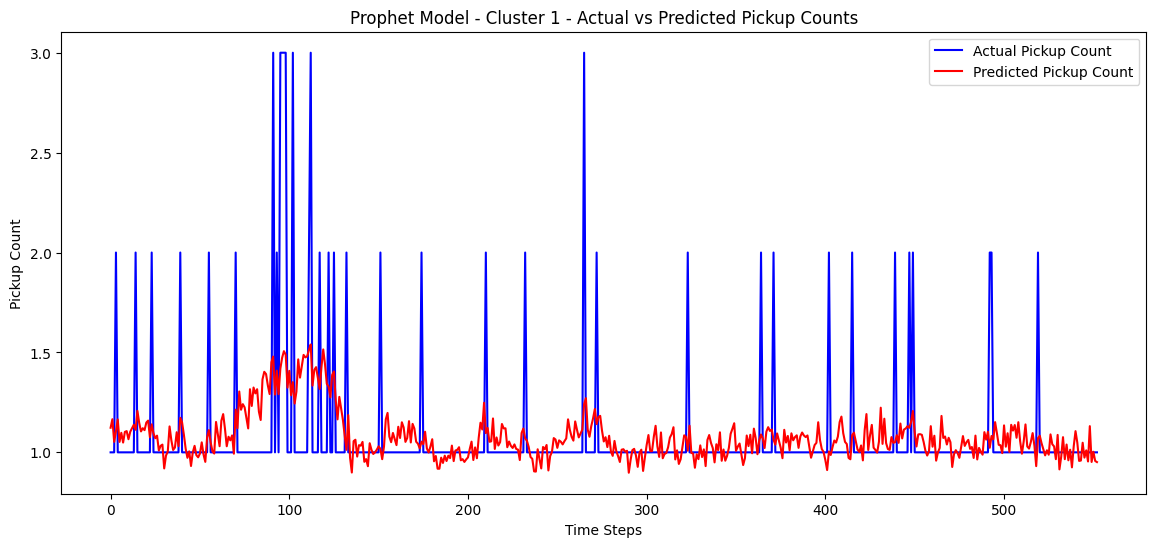


Training Prophet model for Cluster 2...


06:43:08 - cmdstanpy - INFO - Chain [1] start processing
06:43:08 - cmdstanpy - INFO - Chain [1] done processing


Cluster 2 - MAE: 171.44, RMSE: 249.90


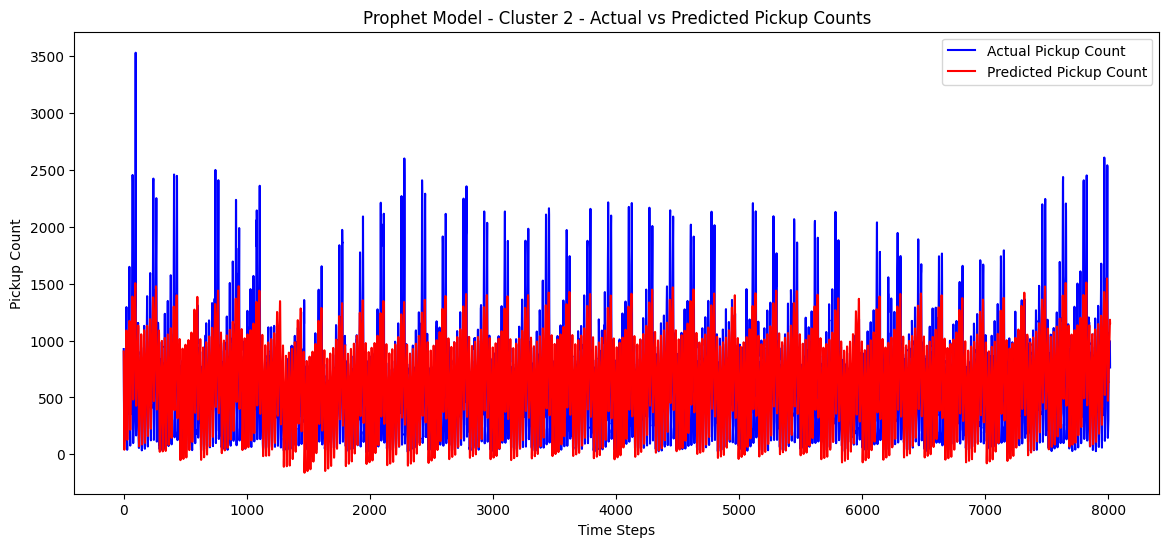


Training Prophet model for Cluster 3...


06:43:09 - cmdstanpy - INFO - Chain [1] start processing
06:43:10 - cmdstanpy - INFO - Chain [1] done processing


Cluster 3 - MAE: 2.59, RMSE: 3.78


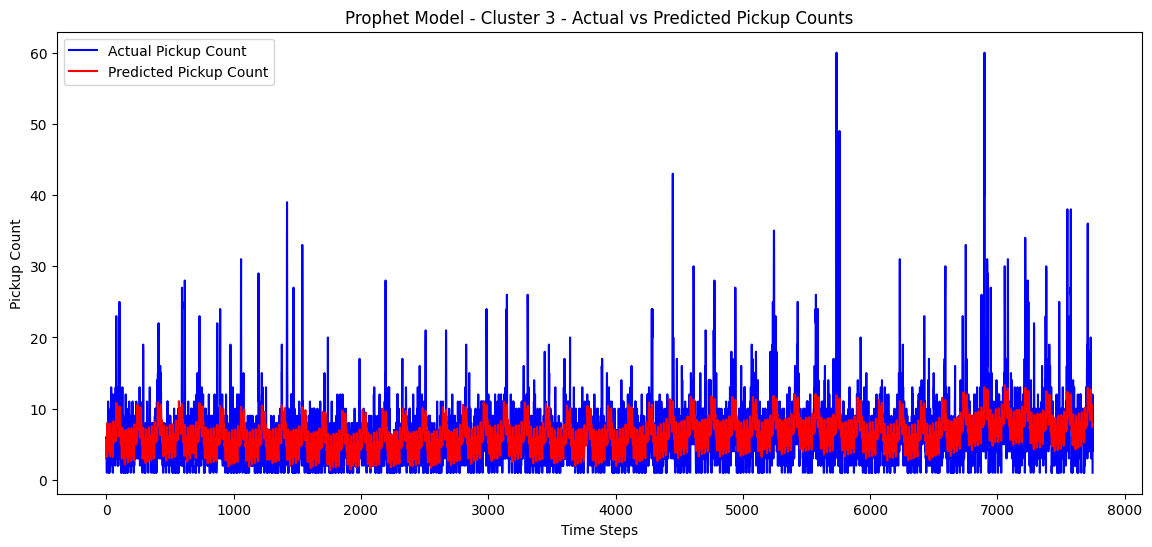


Training Prophet model for Cluster 4...


06:43:11 - cmdstanpy - INFO - Chain [1] start processing
06:43:11 - cmdstanpy - INFO - Chain [1] done processing


Cluster 4 - MAE: 6.16, RMSE: 15.32


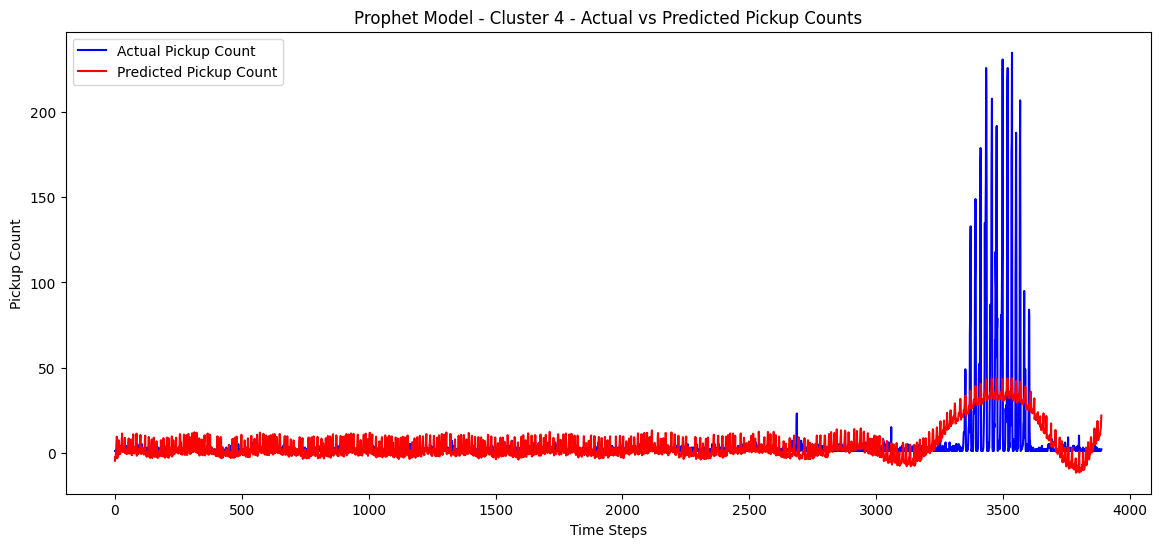

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import holidays
from prophet import Prophet

# Data Preprocessing Function (same as above)
def data_preprocessing_hourly(
    trips_parquet='filtered_df_2.parquet',
    clusters_csv='df_clusters.csv'
):
    # ... (same as previous definition)
    # [Omitted for brevity]
    return df_hourly

# Load and preprocess data
df_hourly = data_preprocessing_hourly(
    trips_parquet='filtered_df_2.parquet',
    clusters_csv='df_clusters.csv'
)

# Prepare a dictionary to store models and metrics
prophet_models = {}
prophet_metrics = {}

# Initialize US holidays
us_holidays = holidays.UnitedStates()

# Loop through each cluster
for cluster in df_hourly['cluster'].unique():
    print(f"\nTraining Prophet model for Cluster {cluster}...")
    
    # Filter data for the cluster
    cluster_data = df_hourly[df_hourly['cluster'] == cluster].copy()
    
    # Prepare data for Prophet
    prophet_df = cluster_data[['pickup_hour', 'pickup_count']].rename(columns={
        'pickup_hour': 'ds',
        'pickup_count': 'y'
    })
    
    # Initialize Prophet model with weekly and daily seasonality
    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,  # Adjust based on data
        holidays=pd.DataFrame({
            'holiday': 'US_holiday',
            'ds': list(us_holidays),
            'lower_window': 0,
            'upper_window': 1,
        })
    )
    
    # Fit the model
    model.fit(prophet_df)
    
    # Store the model
    prophet_models[cluster] = model
    
    # Make future dataframe for predictions
    future = model.make_future_dataframe(periods=0, freq='H')  # No future periods
    
    # Predict
    forecast = model.predict(future)
    
    # Extract predictions corresponding to original data
    y_pred = forecast['yhat'].values
    y_actual = prophet_df['y'].values
    
    # Evaluation Metrics
    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    prophet_metrics[cluster] = {'MAE': mae, 'RMSE': rmse}
    print(f"Cluster {cluster} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    
    # Visualization: Actual vs Predicted
    plt.figure(figsize=(14, 6))
    plt.plot(y_actual, label='Actual Pickup Count', color='blue')
    plt.plot(y_pred, label='Predicted Pickup Count', color='red')
    plt.title(f'Prophet Model - Cluster {cluster} - Actual vs Predicted Pickup Counts')
    plt.xlabel('Time Steps')
    plt.ylabel('Pickup Count')
    plt.legend()
    plt.show()


Outlier Removal (IQR): Removed 62 outliers from cluster

Processing Cluster 0...
Training XGBoost Regressor with weights...
Training completed.
XGBoost Regressor - Cluster 0 - Weighted MAE: 5031.73, Weighted RMSE: 6373.82


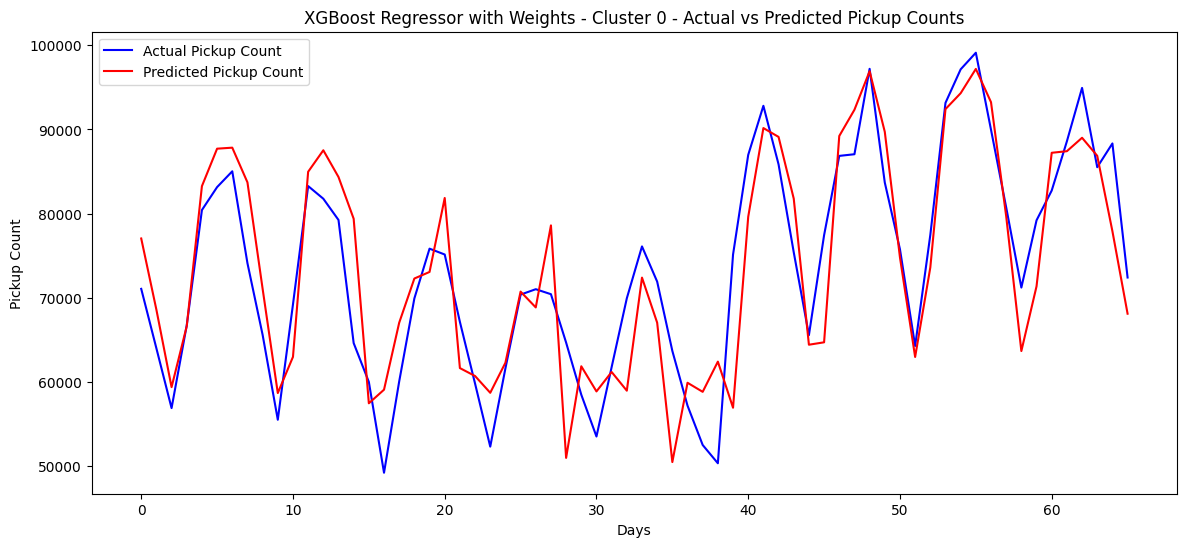

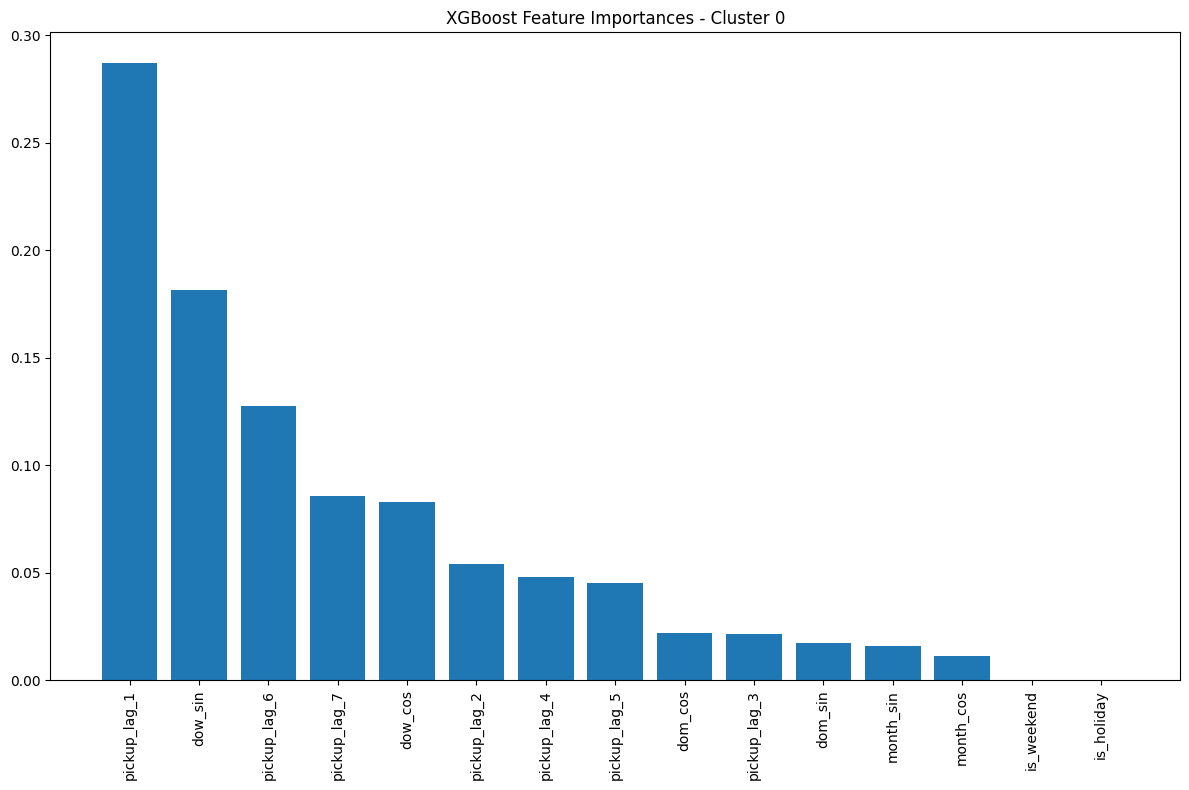


Processing Cluster 1...
Training XGBoost Regressor with weights...
Training completed.
XGBoost Regressor - Cluster 1 - Weighted MAE: 1.00, Weighted RMSE: 1.22


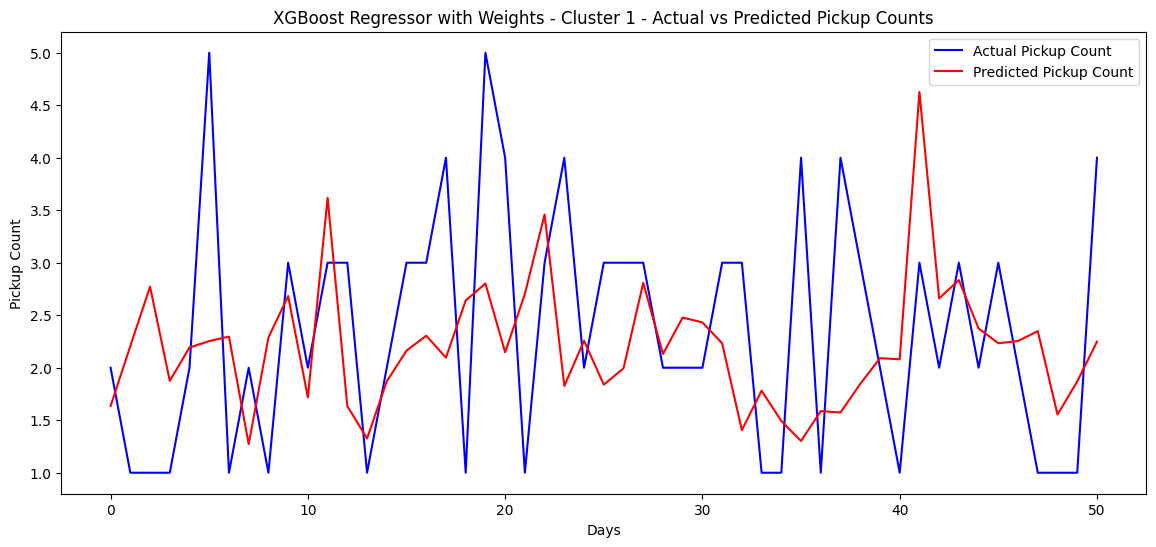

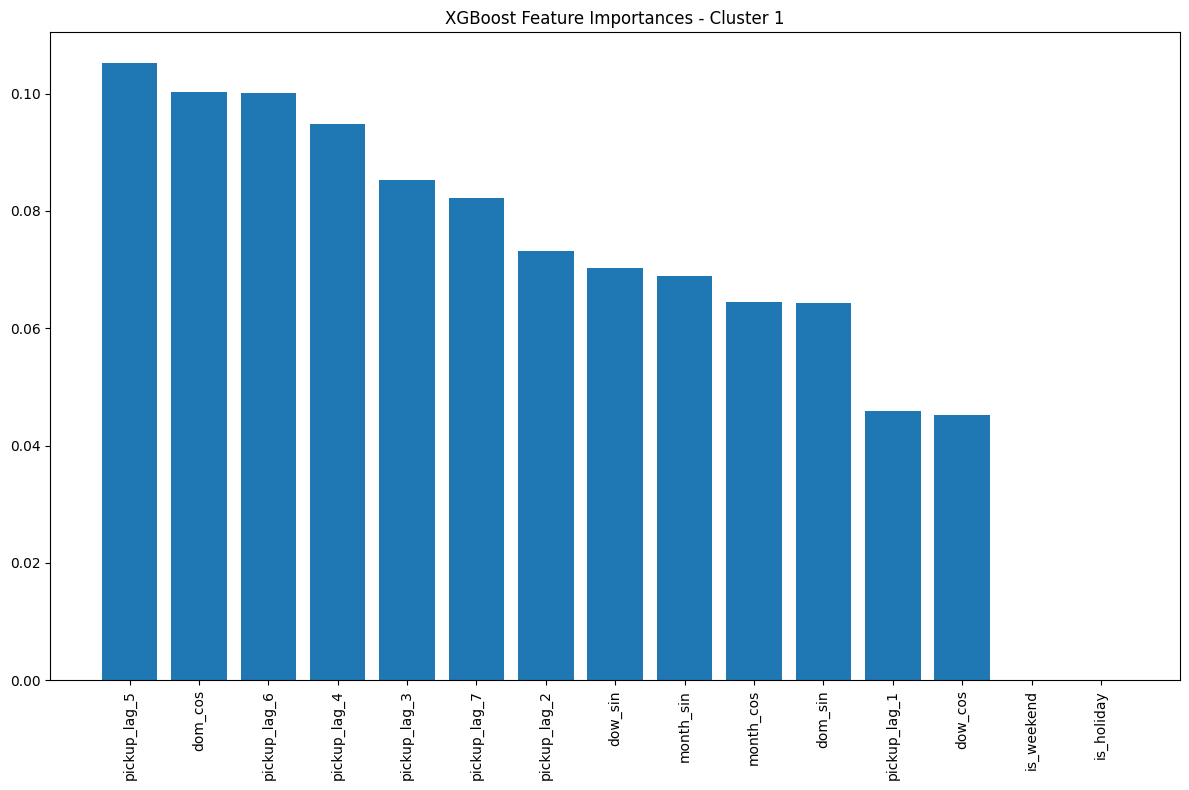


Processing Cluster 2...
Training XGBoost Regressor with weights...
Training completed.
XGBoost Regressor - Cluster 2 - Weighted MAE: 883.82, Weighted RMSE: 1431.94


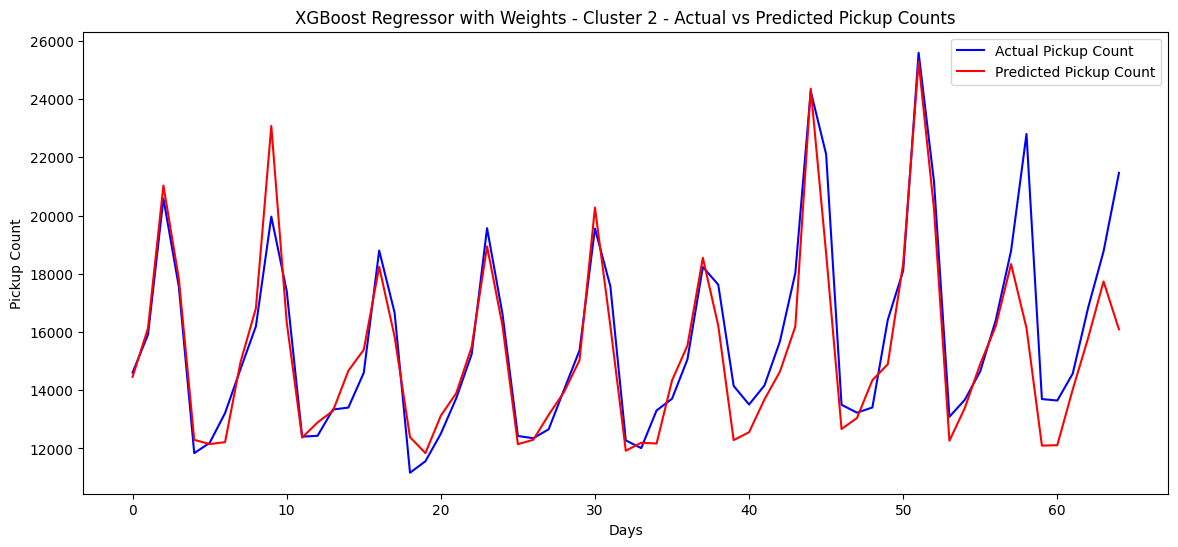

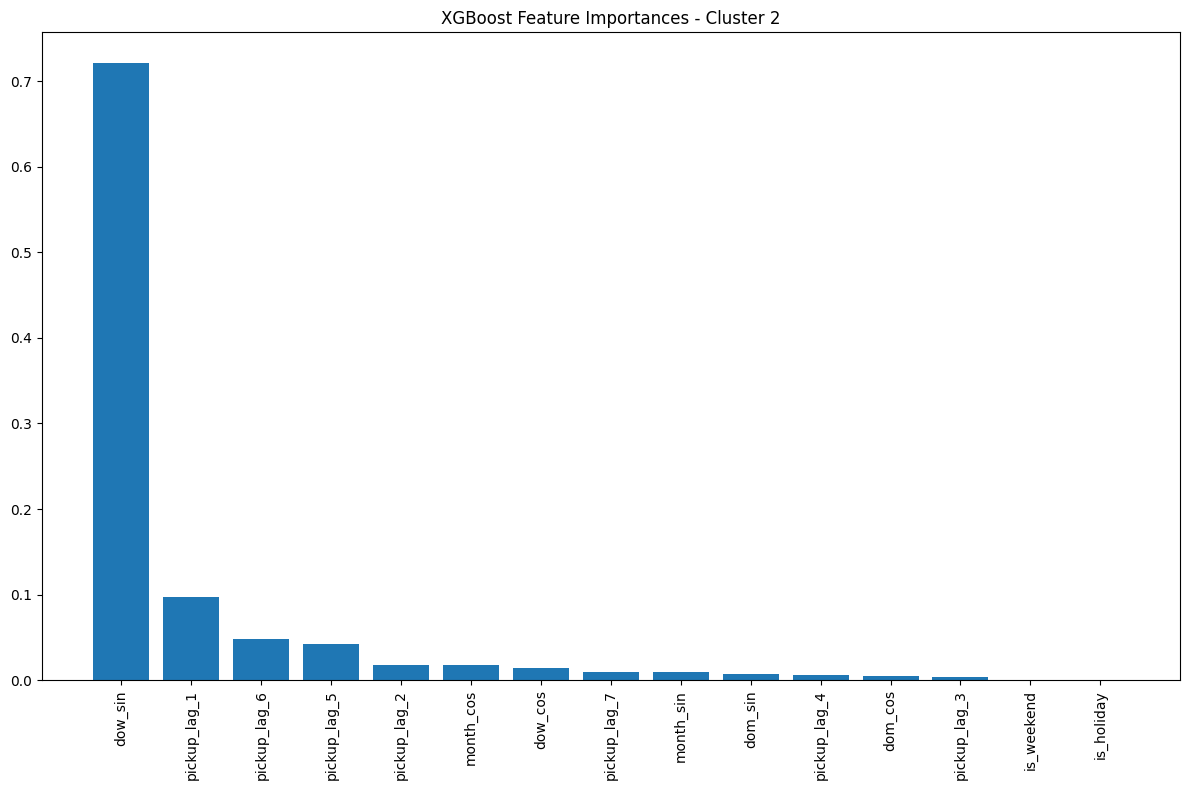


Processing Cluster 3...
Training XGBoost Regressor with weights...
Training completed.
XGBoost Regressor - Cluster 3 - Weighted MAE: 19.48, Weighted RMSE: 25.67


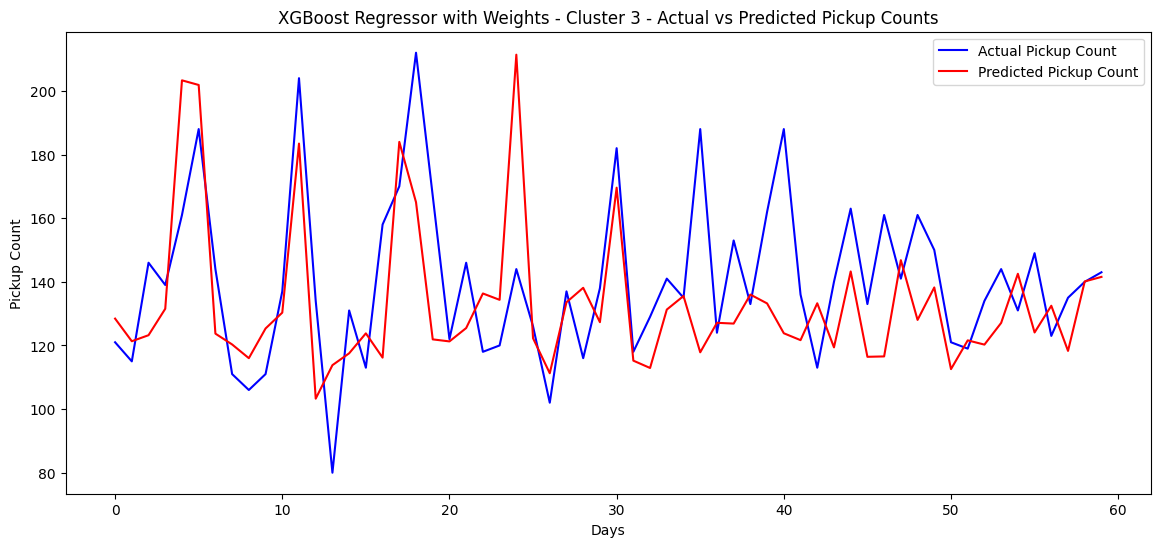

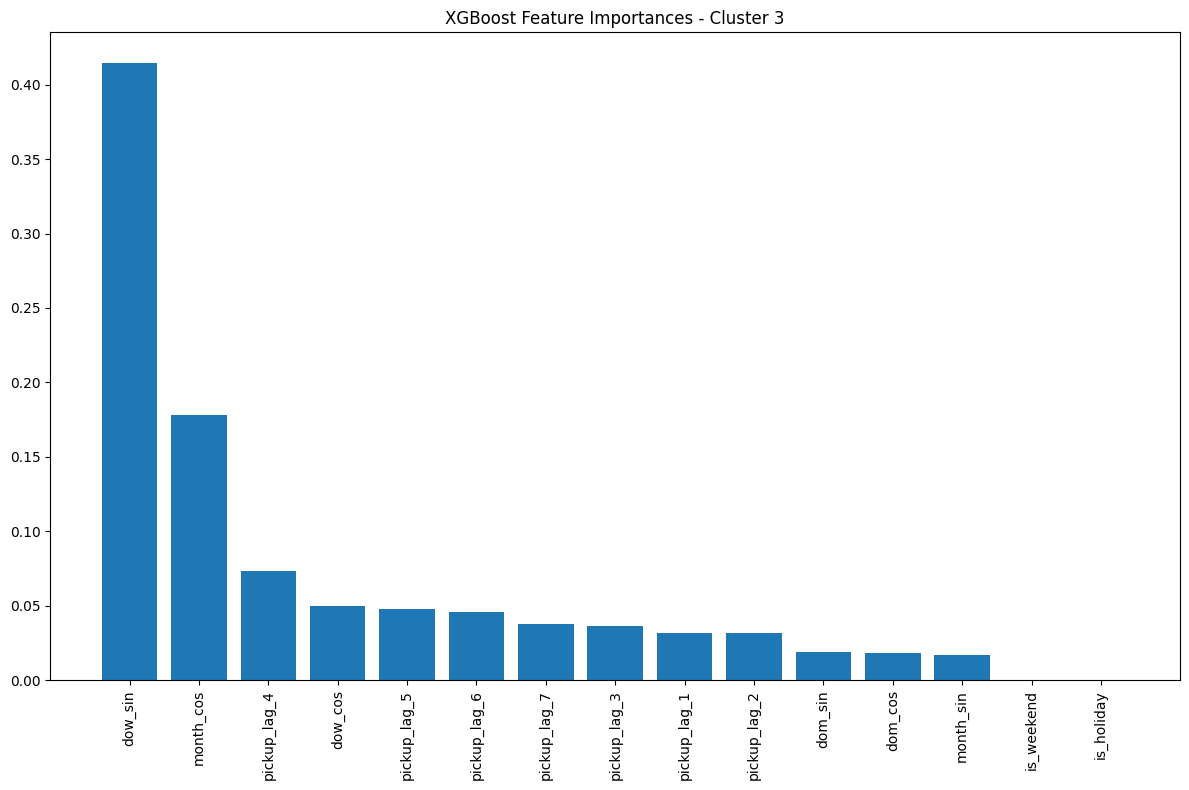


Processing Cluster 4...
Training XGBoost Regressor with weights...
Training completed.
XGBoost Regressor - Cluster 4 - Weighted MAE: 5.60, Weighted RMSE: 7.37


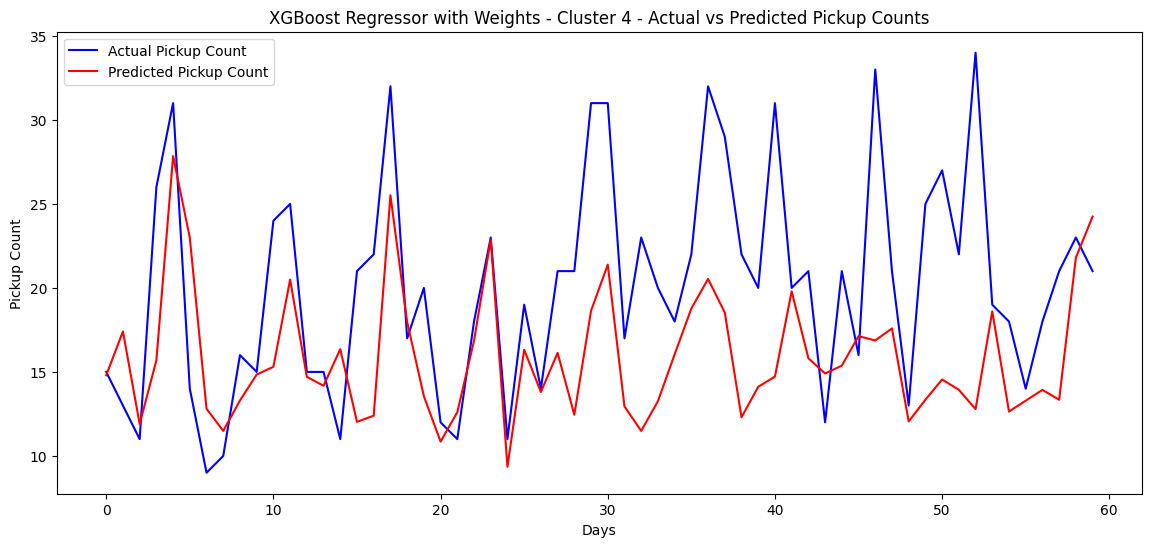

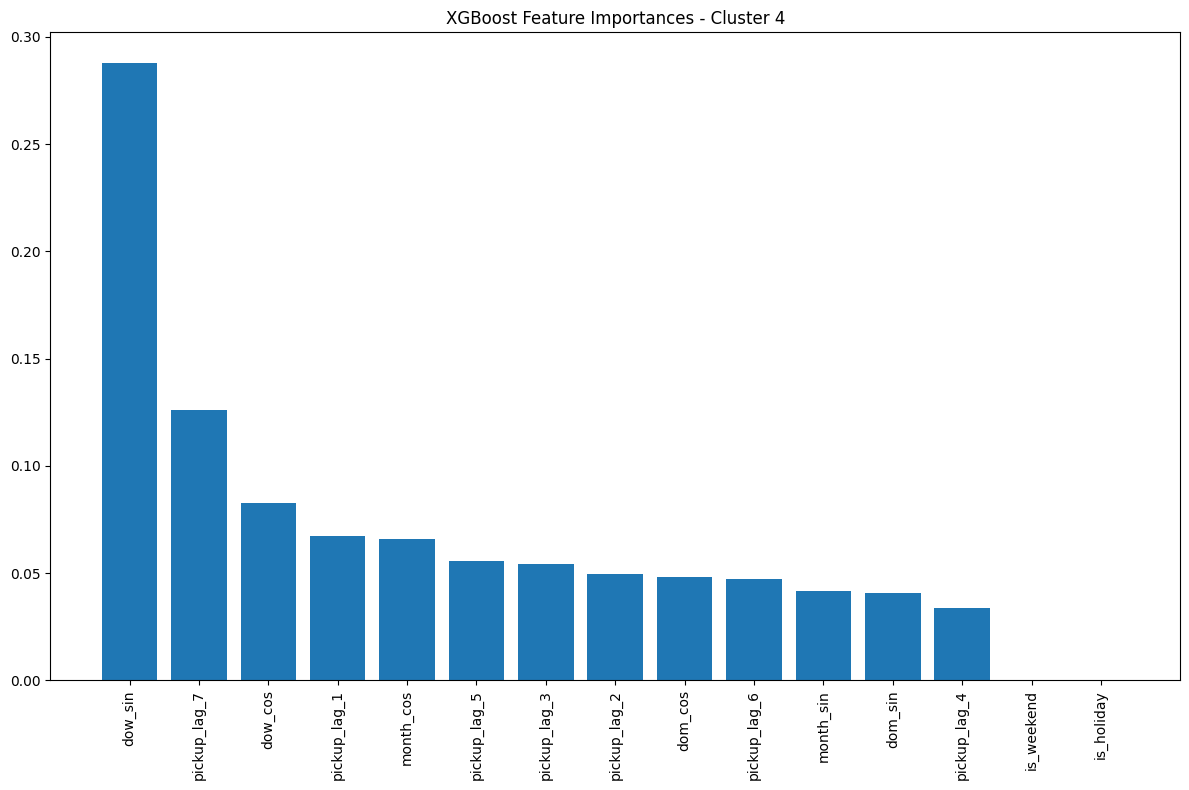

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import holidays
import warnings
import joblib

warnings.filterwarnings('ignore')  # To suppress warnings for cleaner output

# Outlier Removal Function
def remove_outliers(df, cluster_col='cluster', target_col='pickup_count', method='iqr', factor=1.5):
    """
    Removes outliers from the target column within each cluster using the specified method.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        cluster_col (str): The column name representing clusters.
        target_col (str): The column name of the target variable.
        method (str): The method for outlier detection ('iqr' or 'zscore').
        factor (float): The factor to determine the threshold.
        
    Returns:
        pd.DataFrame: The DataFrame with outliers removed.
    """
    if method == 'iqr':
        # Calculate Q1 and Q3 for each cluster
        Q1 = df.groupby(cluster_col)[target_col].quantile(0.25)
        Q3 = df.groupby(cluster_col)[target_col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        # Merge bounds back to the DataFrame
        df = df.merge(Q1.rename('Q1'), on=cluster_col)
        df = df.merge(Q3.rename('Q3'), on=cluster_col)
        df = df.merge(IQR.rename('IQR'), on=cluster_col)
        df = df.merge(lower_bound.rename('lower_bound'), on=cluster_col)
        df = df.merge(upper_bound.rename('upper_bound'), on=cluster_col)
        
        # Filter out outliers
        initial_count = len(df)
        df = df[(df[target_col] >= df['lower_bound']) & (df[target_col] <= df['upper_bound'])]
        final_count = len(df)
        print(f"Outlier Removal (IQR): Removed {initial_count - final_count} outliers from {cluster_col}")
        
        # Drop the additional columns
        df = df.drop(['Q1', 'Q3', 'IQR', 'lower_bound', 'upper_bound'], axis=1)
        
    elif method == 'zscore':
        from scipy import stats
        
        # Calculate Z-scores within each cluster
        df['z_score'] = df.groupby(cluster_col)[target_col].transform(lambda x: np.abs(stats.zscore(x, nan_policy='omit')))
        
        # Define threshold
        df = df[df['z_score'] < factor]
        print(f"Outlier Removal (Z-score): Removed outliers with z-score >= {factor} from {cluster_col}")
        
        # Drop the z_score column
        df = df.drop(['z_score'], axis=1)
        
    else:
        raise ValueError("Unsupported method. Choose 'iqr' or 'zscore'.")
    
    return df

# Data Preprocessing Function (Daily Aggregation with Separate Clusters)
def data_preprocessing_daily(
    trips_parquet='filtered_df_2.parquet',
    clusters_csv='df_clusters.csv',
    outlier_method='iqr',  # Choose 'iqr' or 'zscore'
    outlier_factor=1.5
):
    """
    Loads the taxi trips and cluster info, merges them,
    computes pickup counts per cluster per day,
    removes outliers and random peaks,
    assigns weights based on pickup counts,
    and adds cyclical day-of-week, month, and holiday features.
    Returns df_daily.
    """
    # Load taxi trips
    df_trips = pd.read_parquet(trips_parquet)
    
    # Load cluster info
    df_clusters = pd.read_csv(clusters_csv)
    
    # Merge on PULocationID and zone_id
    df_trips = df_trips.merge(df_clusters, left_on="PULocationID", right_on="zone_id", how="left")
    
    # Handle missing clusters
    missing_clusters = df_trips['cluster'].isnull().sum()
    if missing_clusters > 0:
        print(f"Warning: {missing_clusters} trips have missing cluster information. Dropping these rows.")
        df_trips = df_trips.dropna(subset=['cluster'])
    
    # Ensure datetime
    df_trips['tpep_pickup_datetime'] = pd.to_datetime(df_trips['tpep_pickup_datetime'])
    
    # Extract day (rounded down to the day)
    df_trips['pickup_day'] = df_trips['tpep_pickup_datetime'].dt.floor('D')
    
    # Group by cluster & day to get pickup counts
    df_daily = df_trips.groupby(['cluster', 'pickup_day']).size().reset_index(name='pickup_count')
    
    # Basic time features
    df_daily['day_of_week'] = df_daily['pickup_day'].dt.weekday  # Monday=0, Sunday=6
    df_daily['month'] = df_daily['pickup_day'].dt.month
    df_daily['day_of_month'] = df_daily['pickup_day'].dt.day  # Day of the month (1-31)
    
    # Holiday indicator
    us_holidays = holidays.UnitedStates()
    df_daily['is_holiday'] = df_daily['pickup_day'].dt.date.isin(us_holidays).astype(int)
    
    # Weekend indicator
    df_daily['is_weekend'] = df_daily['day_of_week'].isin([5, 6]).astype(int)
    
    # Cyclical encoding for day-of-week
    df_daily['dow_sin'] = np.sin(2 * np.pi * df_daily['day_of_week'] / 7)
    df_daily['dow_cos'] = np.cos(2 * np.pi * df_daily['day_of_week'] / 7)
    
    # Cyclical encoding for month
    df_daily['month_sin'] = np.sin(2 * np.pi * (df_daily['month'] - 1) / 12)
    df_daily['month_cos'] = np.cos(2 * np.pi * (df_daily['month'] - 1) / 12)
    
    # Cyclical encoding for day of month (optional, for capturing monthly patterns)
    df_daily['dom_sin'] = np.sin(2 * np.pi * (df_daily['day_of_month'] - 1) / 31)
    df_daily['dom_cos'] = np.cos(2 * np.pi * (df_daily['day_of_month'] - 1) / 31)
    
    # Drop 'day_of_month' if not needed
    df_daily.drop(['day_of_month'], axis=1, inplace=True)
    
    # Sort by cluster & day
    df_daily = df_daily.sort_values(['cluster', 'pickup_day']).reset_index(drop=True)
    
    # Remove Outliers and Random Peaks
    df_daily = remove_outliers(
        df_daily,
        cluster_col='cluster',
        target_col='pickup_count',
        method=outlier_method,
        factor=outlier_factor
    )
    
    # Assign weights based on the original pickup_count
    df_daily['weight'] = df_daily['pickup_count'].apply(lambda x: 1 + 0.01 * x).clip(upper=10)
    
    return df_daily

# Lag Features Function (Daily Lags)
def create_lag_features_daily(df, lags=7):
    """
    Creates lag features for the pickup_count_scaled column.
    
    Args:
        df (pd.DataFrame): The DataFrame containing pickup counts per cluster.
        lags (int): Number of lag days to create features for.
    
    Returns:
        pd.DataFrame: DataFrame with new lag features.
    """
    for lag in range(1, lags + 1):
        df[f'pickup_lag_{lag}'] = df.groupby('cluster')['pickup_count_scaled'].shift(lag)
    return df

# Load and preprocess data with separate clusters and outlier removal
df_daily = data_preprocessing_daily(
    trips_parquet='filtered_df_2.parquet',
    clusters_csv='df_clusters.csv',
    outlier_method='iqr',  # Choose 'iqr' or 'zscore'
    outlier_factor=1.5
)

# Apply log1p transformation to the target variable
df_daily['pickup_count_log'] = np.log1p(df_daily['pickup_count'])

# Feature Selection
feature_cols = ['dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'dom_sin', 'dom_cos', 'is_holiday', 'is_weekend']
target_col = 'pickup_count_log'

# Initialize scaler for features
scaler_features = MinMaxScaler()

# Fit and transform features
df_daily[feature_cols] = scaler_features.fit_transform(df_daily[feature_cols])

# Initialize scaler for target
scaler_target = MinMaxScaler()

# Fit and transform target
df_daily['pickup_count_scaled'] = scaler_target.fit_transform(df_daily[[target_col]])

# Create lag features
df_daily = create_lag_features_daily(df_daily, lags=7)  # Using 7 lag days for the past week

# Drop rows with NaN values resulting from lag features
df_daily = df_daily.dropna().reset_index(drop=True)

# Define final feature set
xgb_feature_cols = feature_cols + [f'pickup_lag_{lag}' for lag in range(1, 8)]  # 7 lag days

# Get unique clusters (including Cluster 0)
clusters = df_daily['cluster'].unique()

# Initialize dictionaries to store models and metrics
models_xgb = {}
metrics_xgb = {}

for cluster in clusters:
    print(f"\nProcessing Cluster {cluster}...")
    
    # Filter data for the current cluster
    cluster_data = df_daily[df_daily['cluster'] == cluster].reset_index(drop=True)
    
    # Check if there's enough data
    if len(cluster_data) < 50:  # Adjusted threshold for daily data
        print(f"Cluster {cluster} has insufficient data ({len(cluster_data)} samples). Skipping...")
        continue
    
    # Split data into train and test sets (80% train, 20% test)
    train_size = int(len(cluster_data) * 0.8)
    train_df = cluster_data.iloc[:train_size]
    test_df = cluster_data.iloc[train_size:]
    
    # Separate features and target
    X_train = train_df[xgb_feature_cols]
    y_train = train_df['pickup_count_scaled']
    weights_train = train_df['weight']
    X_test = test_df[xgb_feature_cols]
    y_test = test_df['pickup_count_scaled']
    
    # Initialize the XGBoost Regressor
    xgb_model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1,
        objective='reg:squarederror'
    )
    
    # Train the model with weights
    print("Training XGBoost Regressor with weights...")
    xgb_model.fit(X_train, y_train, sample_weight=weights_train)
    print("Training completed.")
    
    # Make predictions
    y_pred_scaled_xgb = xgb_model.predict(X_test)
    
    # Inverse transform the predictions and actual values
    y_pred_log = scaler_target.inverse_transform(y_pred_scaled_xgb.reshape(-1, 1)).flatten()
    y_pred = np.expm1(y_pred_log)  # Reverse the log1p transformation
    y_actual_log = scaler_target.inverse_transform(y_test.values.reshape(-1, 1)).flatten()
    y_actual = np.expm1(y_actual_log)
    
    # Evaluation Metrics
    # Weighted MAE and RMSE
    weights_test = test_df['weight']
    mae_weighted = np.sum(weights_test * np.abs(y_actual - y_pred)) / np.sum(weights_test)
    rmse_weighted = np.sqrt(np.sum(weights_test * (y_actual - y_pred) ** 2) / np.sum(weights_test))
    metrics_xgb[cluster] = {'Weighted MAE': mae_weighted, 'Weighted RMSE': rmse_weighted}
    print(f"XGBoost Regressor - Cluster {cluster} - Weighted MAE: {mae_weighted:.2f}, Weighted RMSE: {rmse_weighted:.2f}")
    
    # Store the trained model
    models_xgb[cluster] = xgb_model
    
    # Visualization: Actual vs Predicted
    plt.figure(figsize=(14, 6))
    plt.plot(y_actual, label='Actual Pickup Count', color='blue')
    plt.plot(y_pred, label='Predicted Pickup Count', color='red')
    plt.title(f'XGBoost Regressor with Weights - Cluster {cluster} - Actual vs Predicted Pickup Counts')
    plt.xlabel('Days')
    plt.ylabel('Pickup Count')
    plt.legend()
    plt.show()
    
    # Feature Importance
    importances_xgb = xgb_model.feature_importances_
    indices_xgb = np.argsort(importances_xgb)[::-1]
    feature_names_xgb = X_train.columns
    
    plt.figure(figsize=(12, 8))
    plt.title(f"XGBoost Feature Importances - Cluster {cluster}")
    plt.bar(range(len(importances_xgb)), importances_xgb[indices_xgb], align='center')
    plt.xticks(range(len(importances_xgb)), [feature_names_xgb[i] for i in indices_xgb], rotation=90)
    plt.tight_layout()
    plt.show()
    




In [4]:
# Convert the metrics_xgb dictionary to a DataFrame
metrics_df = pd.DataFrame.from_dict(metrics_xgb, orient='index').reset_index()
metrics_df.rename(columns={'index': 'cluster', 'Weighted MAE': 'MAE', 'Weighted RMSE': 'RMSE'}, inplace=True)

# Optionally, sort the DataFrame by cluster
metrics_df.sort_values('cluster', inplace=True)
metrics_df.reset_index(drop=True, inplace=True)

# Display the metrics in a tabular format
print("\nXGBoost Regressor Evaluation Metrics:")
print(metrics_df.to_string(index=False))


XGBoost Regressor Evaluation Metrics:
 cluster         MAE        RMSE
       0 5031.732008 6373.822569
       1    0.997284    1.224203
       2  883.819832 1431.944165
       3   19.481492   25.673166
       4    5.599008    7.372102



Processing Cluster 0 for Seasonal Naive Forecast...
Seasonal Naive Forecast - Cluster 0 - MAE: 7877.08, RMSE: 9354.99


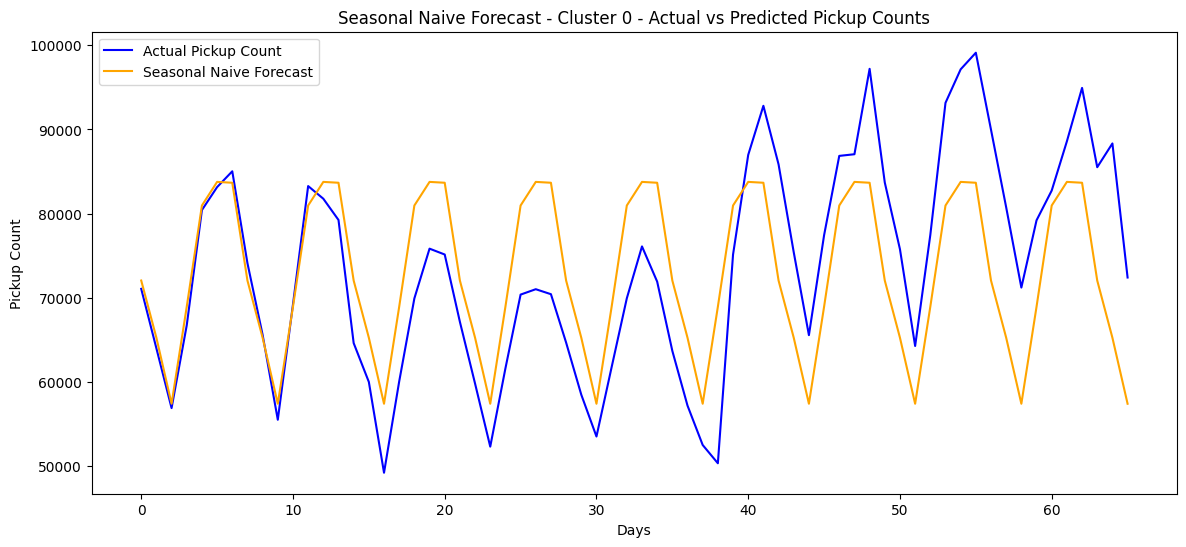


Processing Cluster 1 for Seasonal Naive Forecast...
Seasonal Naive Forecast - Cluster 1 - MAE: 1.24, RMSE: 1.55


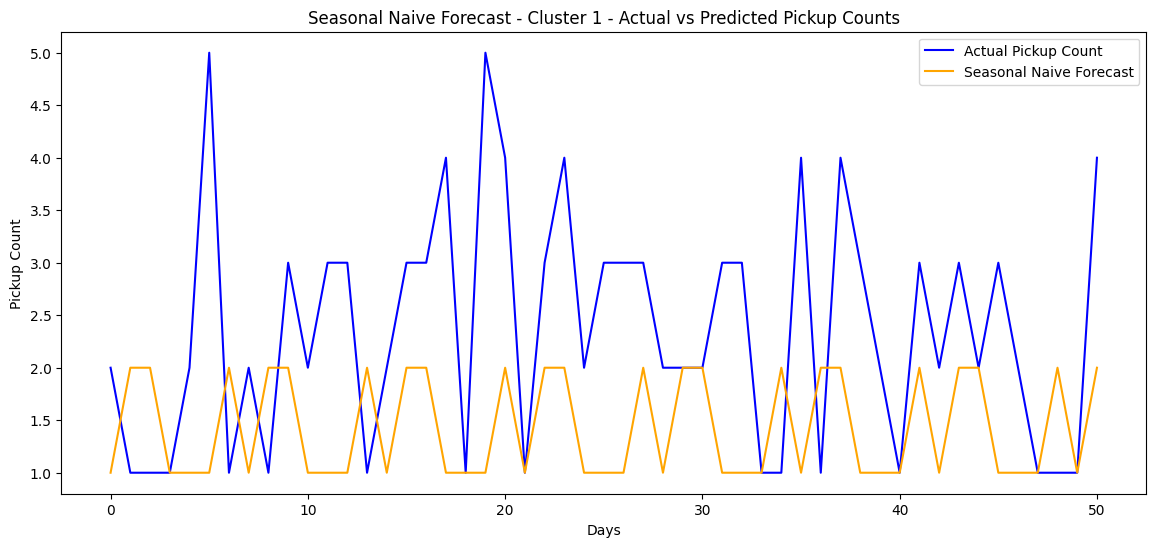


Processing Cluster 2 for Seasonal Naive Forecast...
Seasonal Naive Forecast - Cluster 2 - MAE: 1337.09, RMSE: 1832.95


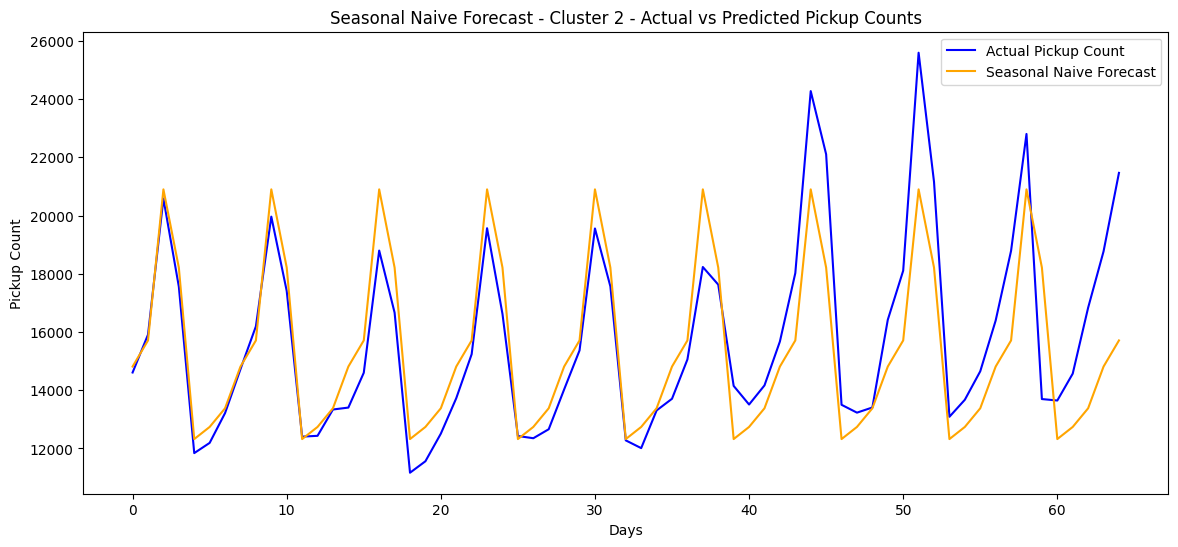


Processing Cluster 3 for Seasonal Naive Forecast...
Seasonal Naive Forecast - Cluster 3 - MAE: 25.92, RMSE: 34.29


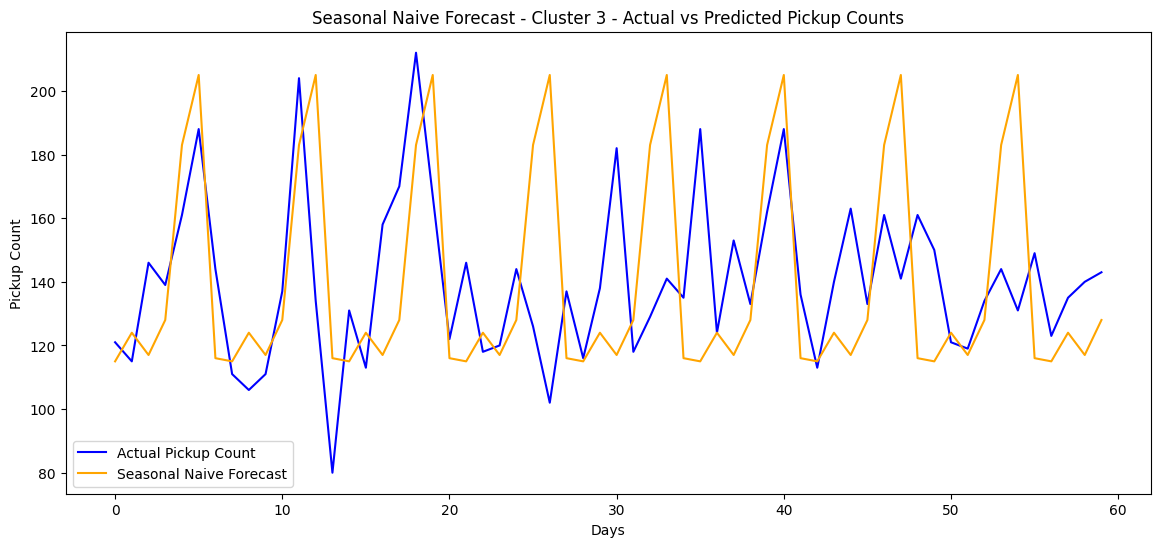


Processing Cluster 4 for Seasonal Naive Forecast...
Seasonal Naive Forecast - Cluster 4 - MAE: 6.83, RMSE: 8.69


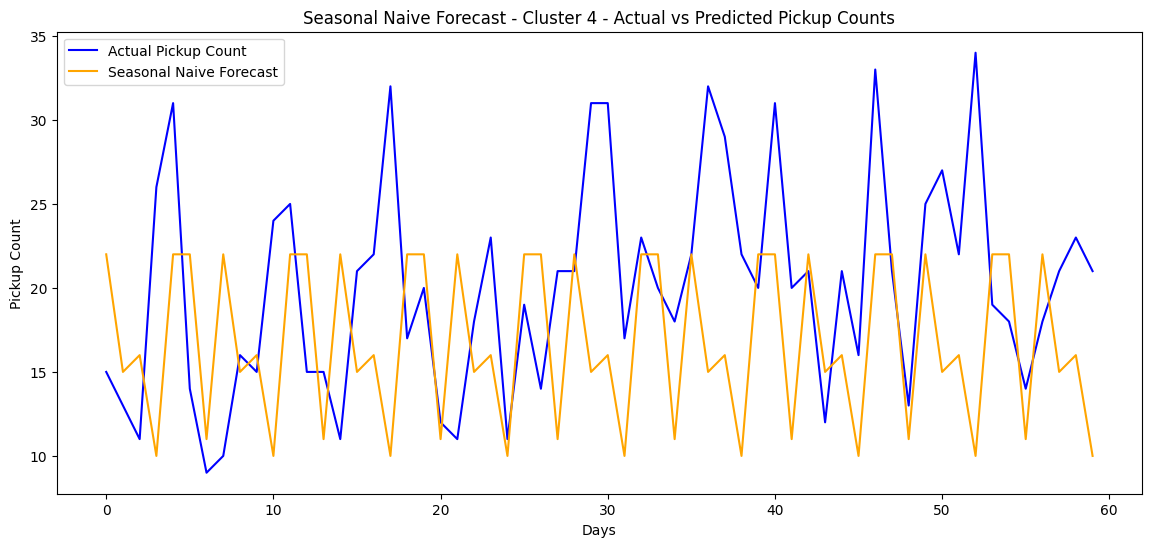

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to create Seasonal Naive Forecast
def seasonal_naive_forecast(df, cluster, season_length=7):
    """
    Creates a seasonal naive forecast for a given cluster.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        cluster (str or int): The cluster identifier.
        season_length (int): The length of the season (default=7 for weekly seasonality).
        
    Returns:
        y_true, y_pred: Actual and predicted pickup counts.
    """
    cluster_data = df[df['cluster'] == cluster].sort_values('pickup_day').reset_index(drop=True)
    
    # Ensure there are enough data points
    if len(cluster_data) < season_length:
        print(f"Not enough data for cluster {cluster} to apply Seasonal Naive Forecast.")
        return None, None
    
    # Split into train and test
    train_size = int(len(cluster_data) * 0.8)
    train = cluster_data.iloc[:train_size]
    test = cluster_data.iloc[train_size:]
    
    # Forecast: pickup count same as the value from season_length days ago
    y_pred = train['pickup_count'].values[-season_length:]
    y_pred = np.tile(y_pred, int(np.ceil(len(test) / season_length)))[:len(test)]
    
    y_true = test['pickup_count'].values
    
    return y_true, y_pred

# Example Usage
clusters = df_daily['cluster'].unique()
metrics_baseline = {}

for cluster in clusters:
    print(f"\nProcessing Cluster {cluster} for Seasonal Naive Forecast...")
    y_true, y_pred = seasonal_naive_forecast(df_daily, cluster, season_length=7)
    
    if y_true is not None and y_pred is not None:
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        metrics_baseline[cluster] = {'MAE': mae, 'RMSE': rmse}
        print(f"Seasonal Naive Forecast - Cluster {cluster} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")
        
        # Visualization
        plt.figure(figsize=(14, 6))
        plt.plot(y_true, label='Actual Pickup Count', color='blue')
        plt.plot(y_pred, label='Seasonal Naive Forecast', color='orange')
        plt.title(f'Seasonal Naive Forecast - Cluster {cluster} - Actual vs Predicted Pickup Counts')
        plt.xlabel('Days')
        plt.ylabel('Pickup Count')
        plt.legend()
        plt.show()


In [3]:
# Convert metrics_baseline dictionary to DataFrame for better readability
baseline_metrics_df = pd.DataFrame(metrics_baseline).T  # Transpose to have clusters as rows
baseline_metrics_df.index.name = 'cluster'
baseline_metrics_df.reset_index(inplace=True)

print("\nSeasonal Naive Forecast Evaluation Metrics:")
print(baseline_metrics_df)



Seasonal Naive Forecast Evaluation Metrics:
   cluster          MAE         RMSE
0        0  7877.075758  9354.990782
1        1     1.235294     1.552986
2        2  1337.092308  1832.950236
3        3    25.916667    34.291641
4        4     6.833333     8.689074
